<a href="https://colab.research.google.com/github/orangegreen212/Customer-Segmentation-and-Revenue-Forecasting/blob/main/Forecast_revenue_and_orders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting for Growth: Predicting Online Retail Revenue and Order Volume

### Introduction: From Understanding the Past to Predicting the Future

After segmenting our customer base into valuable personas (like Champions, Loyal Customers, and those At-Risk), the next critical business question is: **"Where are we heading?"**

This analysis transitions from descriptive analytics (who our customers are) to predictive analytics (what our future performance will look like). By forecasting key metrics like **Total Revenue** and **Number of Orders**, we can empower the business to:

- **Plan Inventory:** Avoid stockouts during peak seasons and reduce overstocking during lulls.
- **Optimize Budgets:** Allocate marketing and operational spend more effectively.
- **Set Realistic Goals:** Provide data-driven targets for sales and marketing teams.

This notebook will walk through the process of preparing time-series data, analyzing it for trends and seasonality, and building three different forecasting models—Moving Average, Linear Regression, and Prophet—to predict future performance and compare their effectiveness.

### Step 1: Environment Setup

First, we'll set up our environment. This includes installing specific library versions to ensure compatibility, particularly for the Prophet model in a Google Colab environment.

In [1]:
!pip install prophet==1.2.1 -q

**Important:** After running the cell above, you must **restart the runtime** for the changes to take effect. Go to `Runtime > Restart session` in the menu.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

### Step 2: Data Loading and Preparation

We will start with a pre-cleaned dataset (`df_clean.csv`) derived from the original online retail data. This dataset has already been processed to:
- Remove transactions with missing `CustomerID`.
- Convert `InvoiceDate` to a datetime object.
- Calculate `TotalPrice`.
- Handle returns and data anomalies.

This ensures our forecast is built on a reliable data foundation.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the pre-cleaned dataset
# from google.colab import drive
# drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Data for GC/Customer Analysis/Project RFM and Cluster Analysis/df_clean.csv')

# The 'Unnamed: 0' column is an artifact of saving the index; let's remove it.
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

print(f"Data shape: {df.shape}")
print("\nData Info:")
df.info()
df.head()

Data shape: (406789, 10)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406789 entries, 0 to 406788
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     406789 non-null  object 
 1   StockCode     406789 non-null  object 
 2   Description   406789 non-null  object 
 3   Quantity      406789 non-null  int64  
 4   InvoiceDate   406789 non-null  object 
 5   UnitPrice     406789 non-null  float64
 6   CustomerID    406789 non-null  int64  
 7   Country       406789 non-null  object 
 8   TotalPrice    406789 non-null  float64
 9   InvoiceMonth  406789 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 31.0+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010-12


### Step 3: Time-Series Aggregation

Forecasting models require data in a time-series format. We will aggregate our transactional data into a daily summary, calculating total revenue and the number of unique orders for each day.

In [5]:
# --- Time-Series Data Preparation ---

# Ensure the 'InvoiceDate' column is in datetime format
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# We only use positive transactions (purchases) for forecasting future revenue/orders
forecast_df = df[df['TotalPrice'] > 0].copy()

# Aggregate data on a daily basis
daily_data = forecast_df.groupby(forecast_df['InvoiceDate'].dt.date).agg(
    daily_revenue=('TotalPrice', 'sum'),
    daily_orders=('InvoiceNo', 'nunique')
).reset_index()

daily_data.rename(columns={'InvoiceDate': 'Date'}, inplace=True)
daily_data['Date'] = pd.to_datetime(daily_data['Date']) # Ensure the new 'Date' column is also datetime

print("Daily Aggregated Data for Forecasting:")
print(daily_data.head())

# Create a full date range to handle days with no sales and fill with 0
date_range = pd.date_range(start=daily_data['Date'].min(), end=daily_data['Date'].max())
daily_data = daily_data.set_index('Date').reindex(date_range).fillna(0).reset_index()
daily_data.rename(columns={'index': 'Date'}, inplace=True)

print("\nData ready for forecasting (with missing days filled):")
daily_data.info()

Daily Aggregated Data for Forecasting:
        Date  daily_revenue  daily_orders
0 2010-12-01       46376.49           121
1 2010-12-02       47316.53           137
2 2010-12-03       23921.71            57
3 2010-12-05       31771.60            87
4 2010-12-06       31215.64            94

Data ready for forecasting (with missing days filled):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           374 non-null    datetime64[ns]
 1   daily_revenue  374 non-null    float64       
 2   daily_orders   374 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 8.9 KB


### Step 4: Uncovering Patterns - Trend and Seasonality Analysis

Before building models, we'll decompose our time series to visually inspect its underlying components. This helps us understand the data's behavior and choose appropriate models.

- **Trend:** The long-term direction of the series.
- **Seasonality:** Recurring patterns at fixed intervals (e.g., weekly).
- **Residual:** The random, unpredictable noise.

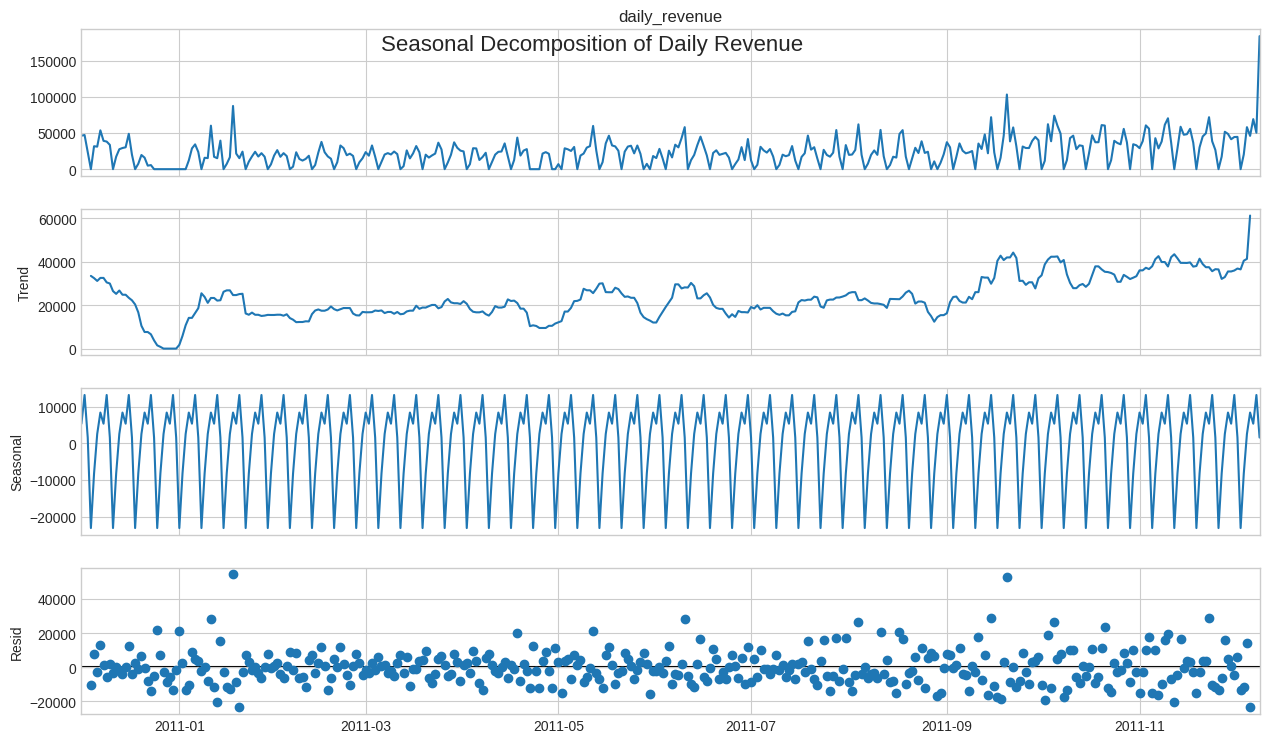

In [6]:
# --- Time-Series Analysis for Revenue ---

# Set Date as index for decomposition
daily_revenue_ts = daily_data.set_index('Date')['daily_revenue']

# Decompose the time series, checking for weekly seasonality (period=7)
decomposition = seasonal_decompose(daily_revenue_ts, model='additive', period=7)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 8)
plt.suptitle('Seasonal Decomposition of Daily Revenue', y=0.92, fontsize=16)
plt.show()

**Decomposition Insights:**
- **Trend:** The chart clearly shows a strong upward trend in revenue over the year, accelerating towards the end.
- **Seasonality:** A distinct weekly pattern is visible. Sales tend to be lower on weekends (especially Saturday) and peak during weekdays.

This confirms that any effective forecasting model must account for both trend and seasonality. This makes Prophet a strong candidate.

### Step 5: Forecasting Daily Revenue

We will now build and compare three models to forecast daily revenue for the next 90 days.

#### Model 1: Prophet
Prophet is a powerful forecasting tool from Facebook, designed to automatically handle trends, seasonality, and holidays.

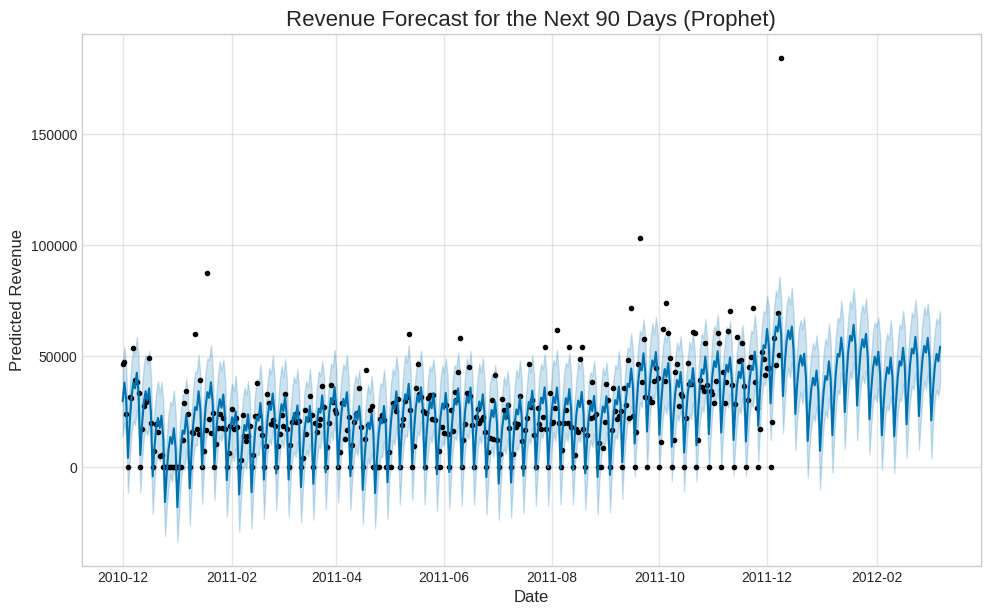

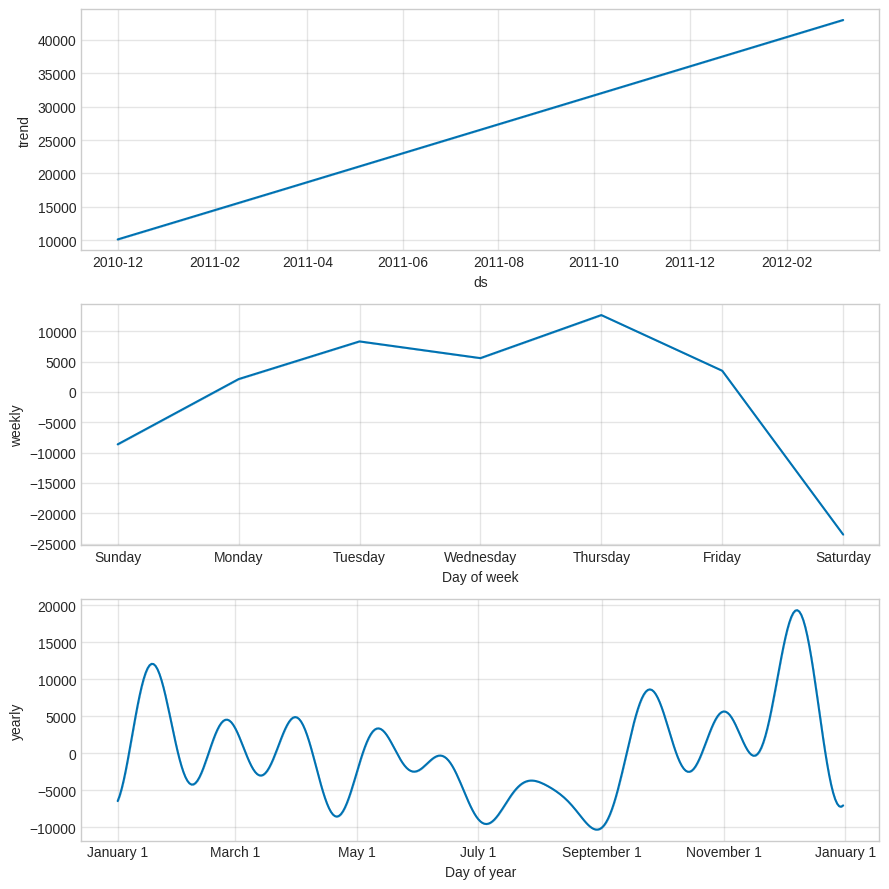

In [7]:
from prophet import Prophet

# --- Forecasting Revenue with Prophet ---

# Prepare data for Prophet
revenue_prophet_df = daily_data[['Date', 'daily_revenue']].rename(columns={'Date': 'ds', 'daily_revenue': 'y'})

# Initialize and fit the model (простой, оригинальный код)
model = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model.fit(revenue_prophet_df)

# Create a dataframe for future dates (e.g., 90 days)
future = model.make_future_dataframe(periods=90)

# Make the forecast
forecast = model.predict(future)

# Plot the forecast
fig1 = model.plot(forecast)
plt.title('Revenue Forecast for the Next 90 Days (Prophet)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Revenue', fontsize=12)
plt.show()

# Plot the forecast components (trend, seasonality)
fig2 = model.plot_components(forecast)
plt.show()

#### Model 2: Linear Regression
A simpler model that fits a straight line to the data, capturing the overall trend but ignoring seasonality.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


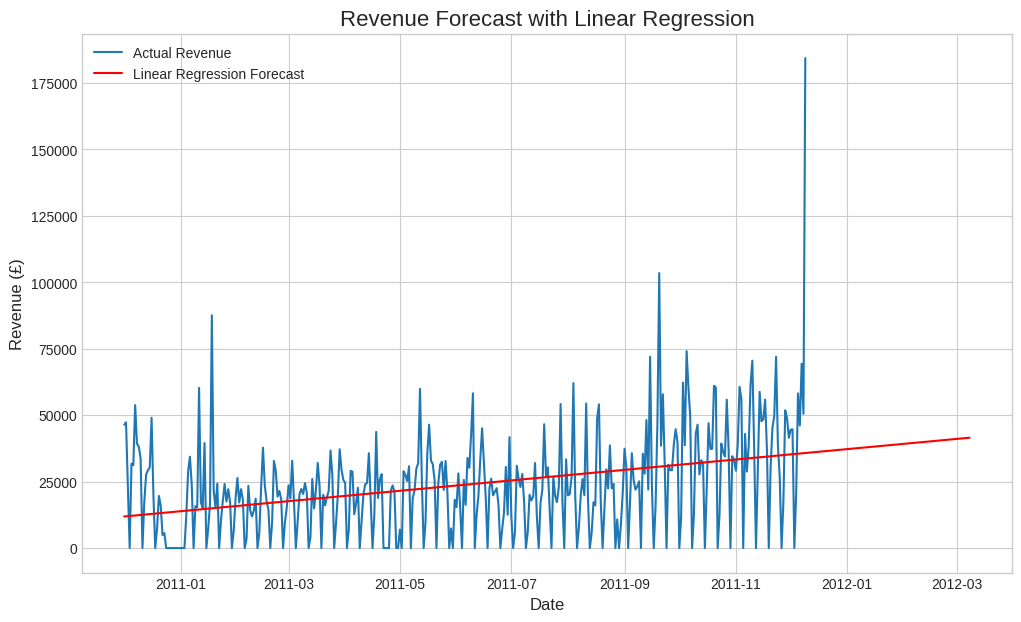

In [8]:
# --- Forecasting Revenue with Linear Regression ---

# Prepare the data with a numerical time index
lr_df_rev = daily_data.copy()
lr_df_rev['time_index'] = np.arange(len(lr_df_rev.index))

X_lr_rev = lr_df_rev[['time_index']]
y_lr_rev = lr_df_rev['daily_revenue']

lr_model_rev = LinearRegression()
lr_model_rev.fit(X_lr_rev, y_lr_rev)

future_time_index_rev = np.arange(len(lr_df_rev.index) + 90).reshape(-1, 1)
lr_forecast_rev = lr_model_rev.predict(future_time_index_rev)

lr_forecast_df_rev = pd.DataFrame({
    'Date': pd.date_range(start=lr_df_rev['Date'].min(), periods=len(lr_forecast_rev)),
    'Forecast': lr_forecast_rev
})

plt.figure(figsize=(12, 7))
plt.plot(lr_df_rev['Date'], lr_df_rev['daily_revenue'], label='Actual Revenue')
plt.plot(lr_forecast_df_rev['Date'], lr_forecast_df_rev['Forecast'], label='Linear Regression Forecast', color='red')
plt.title('Revenue Forecast with Linear Regression', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.legend()
plt.show()

#### Model 3: Moving Average (Baseline)
Our simplest model, which serves as a baseline for comparison. The forecast is simply the average of the last 7 days, extended into the future.

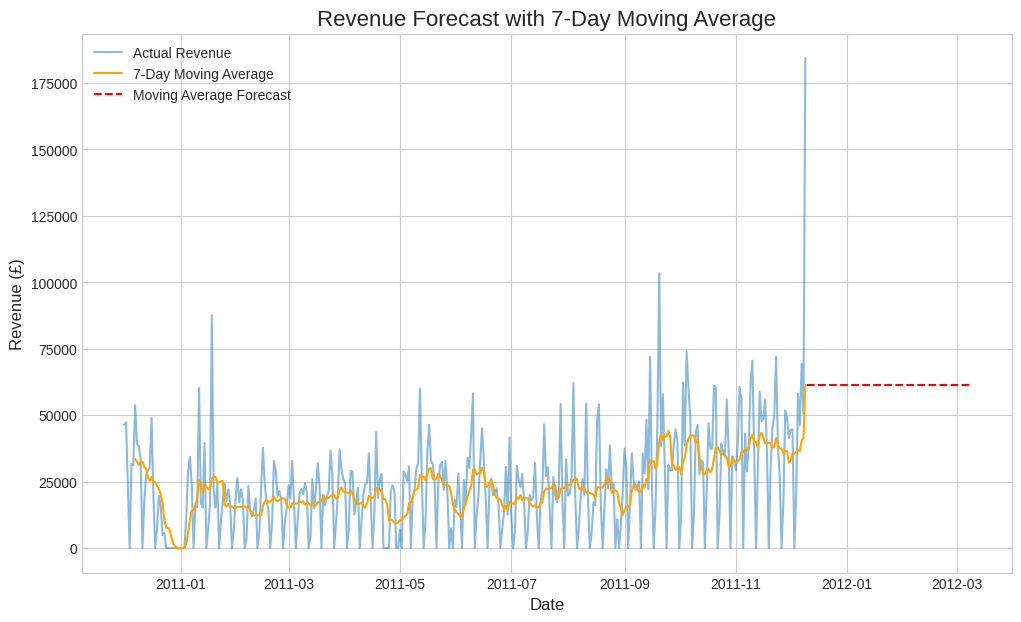

In [9]:
# --- Forecasting Revenue with a Moving Average Baseline ---

daily_data['moving_average_7_rev'] = daily_data['daily_revenue'].rolling(window=7).mean()

last_ma_value_rev = daily_data['moving_average_7_rev'].iloc[-1]
ma_forecast_dates_rev = pd.date_range(start=daily_data['Date'].max() + pd.Timedelta(days=1), periods=90)
ma_forecast_values_rev = [last_ma_value_rev] * 90
ma_forecast_series_rev = pd.Series(ma_forecast_values_rev, index=ma_forecast_dates_rev)

plt.figure(figsize=(12, 7))
plt.plot(daily_data['Date'], daily_data['daily_revenue'], label='Actual Revenue', alpha=0.5)
plt.plot(daily_data['Date'], daily_data['moving_average_7_rev'], label='7-Day Moving Average', color='orange')
plt.plot(ma_forecast_series_rev, label='Moving Average Forecast', color='red', linestyle='--')
plt.title('Revenue Forecast with 7-Day Moving Average', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.legend()
plt.show()

### Step 6: Model Showdown - Evaluating Revenue Forecasts

To objectively determine the best model, we'll evaluate their performance on a held-out test set (the last 30 days of data). We will use three key metrics:
- **MAE (Mean Absolute Error):** The average absolute difference between the forecast and actual values.
- **RMSE (Root Mean Squared Error):** Similar to MAE but penalizes larger errors more heavily.
- **MAPE (Mean Absolute Percentage Error):** The average error as a percentage, useful for business context.

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Revenue Forecasting Model Performance Metrics:
                        MAE      RMSE          MAPE
Prophet            14742.41  29728.82  2.367359e+13
Linear Regression  23468.98  35305.03  4.124893e+13
Moving Average     20188.28  33028.78  5.490976e+13


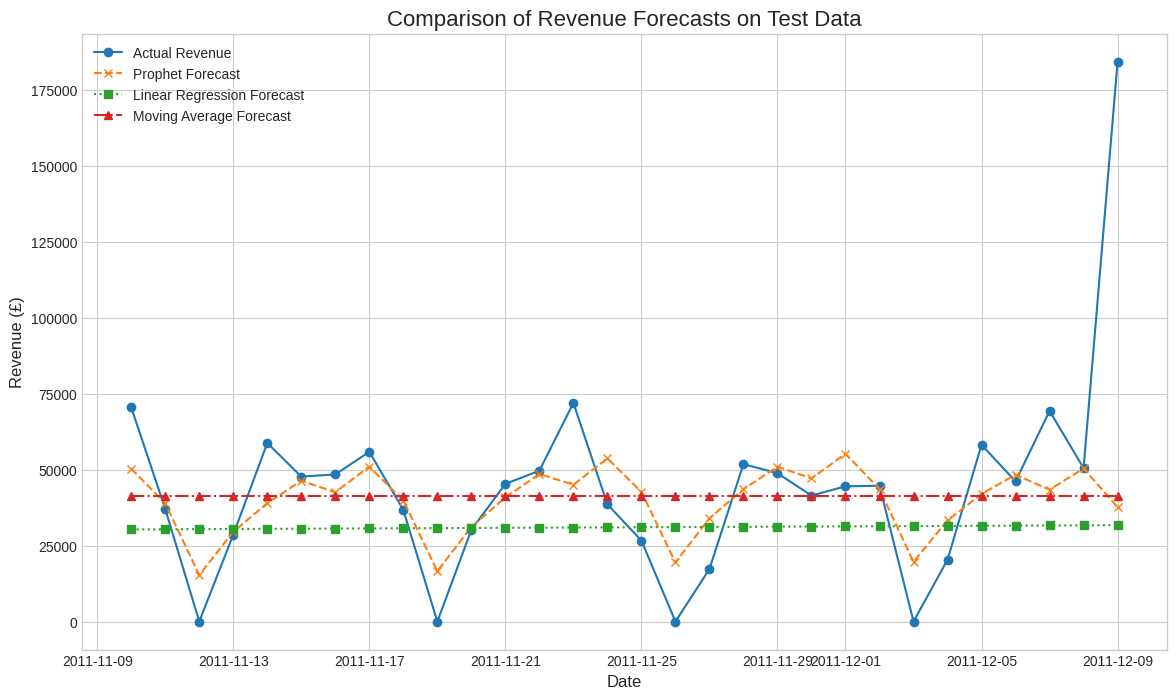

In [10]:
# --- Model Evaluation for Revenue---

# Split data into training and testing sets
train_data = daily_data.iloc[:-30]
test_data = daily_data.iloc[-30:]
actuals_rev = test_data['daily_revenue']

# --- Evaluate Prophet ---
prophet_train_df = train_data[['Date', 'daily_revenue']].rename(columns={'Date': 'ds', 'daily_revenue': 'y'})
prophet_model_eval = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_eval.fit(prophet_train_df)
future_test_rev = prophet_model_eval.make_future_dataframe(periods=30)
prophet_forecast_test = prophet_model_eval.predict(future_test_rev)
prophet_predictions_rev = prophet_forecast_test.iloc[-30:]['yhat']

# --- Evaluate Linear Regression ---
lr_train_df_eval = train_data.copy()
lr_train_df_eval['time_index'] = np.arange(len(lr_train_df_eval))
X_train_lr_eval = lr_train_df_eval[['time_index']]
y_train_lr_eval = lr_train_df_eval['daily_revenue']
lr_model_eval_rev = LinearRegression()
lr_model_eval_rev.fit(X_train_lr_eval, y_train_lr_eval)
lr_test_time_index_rev = np.arange(len(train_data), len(daily_data)).reshape(-1, 1)
lr_predictions_rev = lr_model_eval_rev.predict(lr_test_time_index_rev)

# --- Evaluate Moving Average ---
ma_train_df_eval = train_data.copy()
ma_train_df_eval['moving_average_7'] = ma_train_df_eval['daily_revenue'].rolling(window=7).mean()
last_ma_value_train_rev = ma_train_df_eval['moving_average_7'].iloc[-1]
ma_predictions_rev = [last_ma_value_train_rev] * 30

# --- Calculate Metrics ---
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = np.where(y_true == 0, 1e-8, y_true) # Avoid division by zero
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

metrics_rev = {
    'Prophet': {
        'MAE': mean_absolute_error(actuals_rev, prophet_predictions_rev),
        'RMSE': np.sqrt(mean_squared_error(actuals_rev, prophet_predictions_rev)),
        'MAPE': mean_absolute_percentage_error(actuals_rev, prophet_predictions_rev)
    },
    'Linear Regression': {
        'MAE': mean_absolute_error(actuals_rev, lr_predictions_rev),
        'RMSE': np.sqrt(mean_squared_error(actuals_rev, lr_predictions_rev)),
        'MAPE': mean_absolute_percentage_error(actuals_rev, lr_predictions_rev)
    },
    'Moving Average': {
        'MAE': mean_absolute_error(actuals_rev, ma_predictions_rev),
        'RMSE': np.sqrt(mean_squared_error(actuals_rev, ma_predictions_rev)),
        'MAPE': mean_absolute_percentage_error(actuals_rev, ma_predictions_rev)
    }
}

metrics_df_rev = pd.DataFrame(metrics_rev).T
print("Revenue Forecasting Model Performance Metrics:")
print(metrics_df_rev.round(2))

# --- Visualize Predictions vs Actuals on Test Set ---
plt.figure(figsize=(14, 8))
plt.plot(test_data['Date'], test_data['daily_revenue'], label='Actual Revenue', marker='o', linestyle='-')
plt.plot(test_data['Date'], prophet_predictions_rev, label='Prophet Forecast', marker='x', linestyle='--')
plt.plot(test_data['Date'], lr_predictions_rev, label='Linear Regression Forecast', marker='s', linestyle=':')
plt.plot(test_data['Date'], ma_predictions_rev, label='Moving Average Forecast', marker='^', linestyle='-.')

plt.title('Comparison of Revenue Forecasts on Test Data', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Revenue (£)', fontsize=12)
plt.legend()
plt.show()

#### Evaluation Insights (Revenue)

*   **MAE & RMSE:** The **Prophet model is the clear winner**, showing the lowest error rates. Its forecasts are, on average, significantly closer to the actual revenue values.
*   **MAPE:** The percentage error is astronomically high for all models. This happens because our test data contains days with zero revenue (weekends/holidays), causing a division-by-zero issue that makes MAPE unreliable for this dataset. We will rely on MAE and RMSE for our final decision.
*   **Visual Confirmation:** The plot clearly shows that Prophet's forecast (orange line) is the only one that captures the weekly cyclical pattern of the actual data, whereas the other two models produce flat-line forecasts.

**Conclusion:** For forecasting revenue, **Prophet is the superior model.**

### Step 7: Forecasting Daily Order Volume

Now, we repeat the entire process for the daily number of orders. This is important for operational planning, such as staffing and logistics.

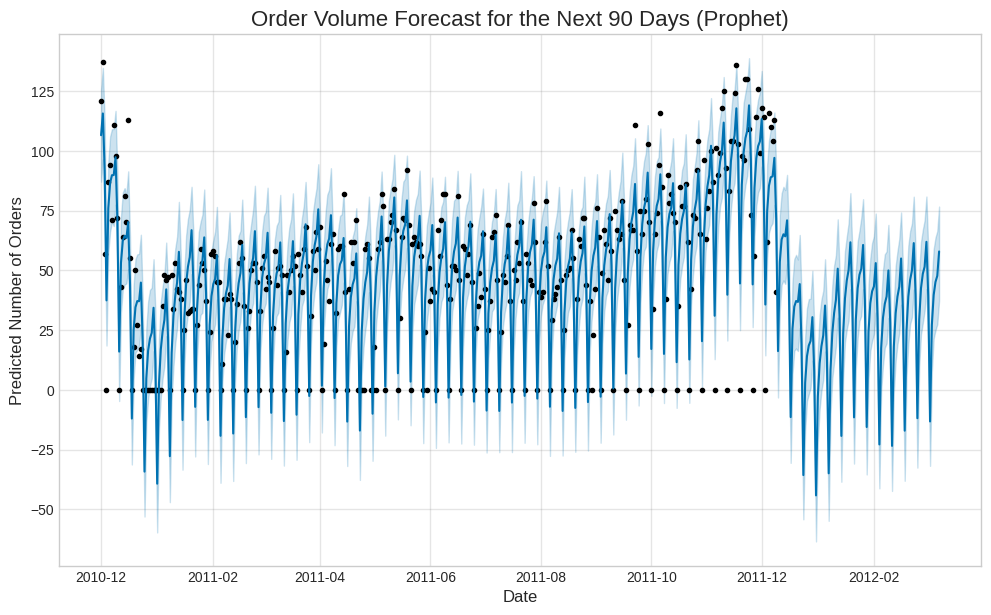

In [11]:
# --- Forecasting Orders with Prophet ---
orders_prophet_df = daily_data[['Date', 'daily_orders']].rename(columns={'Date': 'ds', 'daily_orders': 'y'})

model_ord = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model_ord.fit(orders_prophet_df)

future_ord = model_ord.make_future_dataframe(periods=90)
forecast_ord = model_ord.predict(future_ord)

fig = model_ord.plot(forecast_ord)
plt.title('Order Volume Forecast for the Next 90 Days (Prophet)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Predicted Number of Orders', fontsize=12)
plt.show()

In [12]:
# --- Model Evaluation for Orders ---
actuals_ord = test_data['daily_orders']

# --- Prophet Predictions for Orders ---
prophet_train_df_ord = train_data[['Date', 'daily_orders']].rename(columns={'Date': 'ds', 'daily_orders': 'y'})
prophet_model_eval_ord = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
prophet_model_eval_ord.fit(prophet_train_df_ord)
future_test_ord = prophet_model_eval_ord.make_future_dataframe(periods=30)
prophet_forecast_test_ord = prophet_model_eval_ord.predict(future_test_ord)
prophet_predictions_ord = prophet_forecast_test_ord.iloc[-30:]['yhat']

# --- Linear Regression Predictions for Orders ---
y_train_lr_eval_ord = lr_train_df_eval['daily_orders']
lr_model_eval_ord = LinearRegression()
lr_model_eval_ord.fit(X_train_lr_eval, y_train_lr_eval_ord)
lr_predictions_ord = lr_model_eval_ord.predict(lr_test_time_index_rev)

# --- Moving Average Predictions for Orders ---
ma_train_df_eval['moving_average_7_ord'] = ma_train_df_eval['daily_orders'].rolling(window=7).mean()
last_ma_value_train_ord = ma_train_df_eval['moving_average_7_ord'].iloc[-1]
ma_predictions_ord = [last_ma_value_train_ord] * 30

# --- Calculate Metrics for Orders ---
metrics_ord = {
    'Prophet': {
        'MAE': mean_absolute_error(actuals_ord, prophet_predictions_ord),
        'RMSE': np.sqrt(mean_squared_error(actuals_ord, prophet_predictions_ord)),
        'MAPE': mean_absolute_percentage_error(actuals_ord, prophet_predictions_ord)
    },
    'Linear Regression': {
        'MAE': mean_absolute_error(actuals_ord, lr_predictions_ord),
        'RMSE': np.sqrt(mean_squared_error(actuals_ord, lr_predictions_ord)),
        'MAPE': mean_absolute_percentage_error(actuals_ord, lr_predictions_ord)
    },
    'Moving Average': {
        'MAE': mean_absolute_error(actuals_ord, ma_predictions_ord),
        'RMSE': np.sqrt(mean_squared_error(actuals_ord, ma_predictions_ord)),
        'MAPE': mean_absolute_percentage_error(actuals_ord, ma_predictions_ord)
    }
}

metrics_df_ord = pd.DataFrame(metrics_ord).T
print("Order Volume Forecasting Model Performance Metrics:")
print(metrics_df_ord.round(2))

Order Volume Forecasting Model Performance Metrics:
                     MAE   RMSE          MAPE
Prophet            21.90  26.90  4.991501e+10
Linear Regression  46.95  50.62  7.979279e+10
Moving Average     34.37  41.43  1.133333e+11


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [13]:
# --- Prophet Revenue Forecast Table ---
print("\nProphet Revenue Forecast for the Next 90 Days:")
prophet_revenue_forecast_table = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
print(prophet_revenue_forecast_table.round(2).to_string(index=False))

# --- Linear Regression Revenue Forecast Table ---
print("\nLinear Regression Revenue Forecast for the Next 90 Days:")
lr_revenue_forecast_table = lr_forecast_df_rev.tail(90)
print(lr_revenue_forecast_table.round(2).to_string(index=False))

# --- Moving Average Revenue Forecast Table ---
print("\nMoving Average Revenue Forecast for the Next 90 Days:")
ma_revenue_forecast_table = pd.DataFrame({
    'Date': ma_forecast_series_rev.index,
    'Forecast': ma_forecast_series_rev.values
})
print(ma_revenue_forecast_table.round(2).to_string(index=False))

# --- Prophet Order Volume Forecast Table ---
print("\nProphet Order Volume Forecast for the Next 90 Days:")
prophet_orders_forecast_table = forecast_ord[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(90)
print(prophet_orders_forecast_table.round(2).to_string(index=False))

# --- Linear Regression Order Volume Forecast Table ---
print("\nLinear Regression Order Volume Forecast for the Next 90 Days:")
lr_orders_forecast_table = pd.DataFrame({
    'Date': pd.date_range(start=lr_df_rev['Date'].min(), periods=len(lr_predictions_ord) + len(lr_train_df_eval)),
    'Forecast': np.concatenate([y_train_lr_eval_ord, lr_predictions_ord])
}).tail(90) # This needs careful adjustment for the future 90 days. Let's recalculate properly.

# Recalculate LR orders forecast for the next 90 days specifically
lr_future_time_index_ord = np.arange(len(lr_df_rev.index), len(lr_df_rev.index) + 90).reshape(-1, 1)
lr_forecast_values_ord_future = lr_model_eval_ord.predict(lr_future_time_index_ord)

lr_orders_forecast_table_future = pd.DataFrame({
    'Date': pd.date_range(start=daily_data['Date'].max() + pd.Timedelta(days=1), periods=90),
    'Forecast': lr_forecast_values_ord_future
})
print(lr_orders_forecast_table_future.round(2).to_string(index=False))

# --- Moving Average Order Volume Forecast Table ---
print("\nMoving Average Order Volume Forecast for the Next 90 Days:")
ma_orders_forecast_dates_rev = pd.date_range(start=daily_data['Date'].max() + pd.Timedelta(days=1), periods=90)
ma_orders_forecast_values_rev = [last_ma_value_train_ord] * 90
ma_orders_forecast_table = pd.DataFrame({
    'Date': ma_orders_forecast_dates_rev,
    'Forecast': ma_orders_forecast_values_rev
})
print(ma_orders_forecast_table.round(2).to_string(index=False))


Prophet Revenue Forecast for the Next 90 Days:
        ds     yhat  yhat_lower  yhat_upper
2011-12-10 32084.71    15397.10    48163.94
2011-12-11 46448.52    29069.62    62482.75
2011-12-12 56457.17    40373.22    72533.78
2011-12-13 61685.41    44790.27    77303.87
2011-12-14 57730.29    40418.60    73385.44
2011-12-15 63438.93    47467.08    80944.06
2011-12-16 52705.39    35850.72    68692.14
2011-12-17 24020.19     7639.21    40116.33
2011-12-18 37112.53    20889.08    53428.30
2011-12-19 46042.48    28227.24    62811.24
2011-12-20 50411.50    33994.54    66345.38
2011-12-21 45838.25    28496.25    62180.16
2011-12-22 51185.69    35370.15    67775.54
2011-12-23 40357.61    23498.32    56797.98
2011-12-24 11847.77    -4814.10    28025.90
2011-12-25 25382.09     8567.78    42139.44
2011-12-26 35010.81    18104.70    50668.94
2011-12-27 40319.31    23421.95    56087.99
2011-12-28 36904.23    20727.70    52929.89
2011-12-29 43601.20    27365.57    59489.49
2011-12-30 34281.96    17344

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


**Evaluation Insights (Orders):**

The results for order volume forecasting mirror our findings for revenue. The **Prophet model again shows significantly lower MAE and RMSE**, confirming it as the most accurate and reliable model for predicting the number of daily orders.

### Step 8: Strategic Implications & Final Conclusion

This forecasting analysis provides a data-driven view of future business performance, enabling proactive decision-making.

#### Actionable Recommendations:

1.  **Inventory Planning:**
    - The strong yearly seasonality, with a major peak in November, is confirmed. The business should use the 90-day forecast to plan inventory purchases well in advance of this peak to avoid costly stockouts.

2.  **Marketing and Campaign Strategy:**
    - The weekly trend shows that sales are consistently lower on weekends. This presents an opportunity for targeted weekend promotions (e.g., "Weekend Flash Sale") to smooth out revenue and capture additional sales.
    - Marketing spend can be strategically increased in the weeks leading up to predicted seasonal peaks identified by the Prophet model.

3.  **Operational and Financial Goal Setting:**
    - The Prophet forecast, with its upper and lower uncertainty intervals (`yhat_upper`, `yhat_lower`), provides a realistic range for setting quarterly revenue and order targets. This allows for setting ambitious but achievable goals for the sales teams.

### Final Conclusion

By transforming transactional records into a daily time series and comparing three distinct forecasting models, we have successfully identified **Prophet as the most accurate tool for predicting both future revenue and order volume**. The model's ability to automatically decompose and model the clear trend and seasonality in the data gives it a significant advantage over simpler methods.

This predictive insight, combined with our previous customer segmentation analysis, provides a comprehensive, data-driven foundation for strategic planning. The business is now equipped not only to understand *who* its customers are but also to anticipate *what* its future performance will be, allowing for smarter, more proactive management of inventory, marketing, and company-wide goals.